In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import requests
import os
import json
import pandas as pd
import time
import glob
import pandarallel
pandarallel.pandarallel.initialize()

sample_data = pd.read_csv("/home/phadke/ONR/ONR/lite_data/jan21_nonfiltered_extracted_urls.csv", header=0)

INFO: Pandarallel will run on 128 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
linkframe = sample_data

In [5]:
linkframe.head()

,Unnamed: 0,party,link,author
0,0,BJP,https://twitter.com/rkdugar04/status/138215198...,rkdugar04
1,1,BJP,https://twitter.com/ippatel/status/13813202769...,rkdugar04
2,2,BJP,https://twitter.com/priyankac19/status/1381176...,rkdugar04
3,3,BJP,https://twitter.com/rkdugar04/status/138118354...,rkdugar04
4,4,BJP,https://twitter.com/SushantBSinha/status/13811...,rkdugar04


In [8]:
import json
from tld import get_tld
def get_domain(link):
    try:
        res = get_tld(link, as_object=True)
        return res.fld
    except:
        fakevar=1


linkframe['domain'] = linkframe['link'].parallel_apply(lambda x: get_domain(x))

common_domains = ['twitter.com', 'facebook.com', 'google.com', 'm.tech', 'm.sc', 'b.tech', 'page.link', 'youtu.be', 'bit.ly', 'instagram.com','youtube.com']

filtered_link = linkframe.loc[~linkframe['domain'].isin(common_domains)]

filtered_link.to_csv("/home/phadke/ONR/ONR/lite_data/jan21_filtered_extracted_urls.csv")


In [9]:
filtered_link.head()

,Unnamed: 0,party,link,author,domain
8,8,BJP,https://www.moneycontrol.com/news/india/health...,rkdugar04,moneycontrol.com
9,9,BJP,https://www.moneycontrol.com/news/india/health...,rkdugar04,moneycontrol.com
15,15,BJP,https://experience.glance.com/story/AXiSpxIi?u...,rkdugar04,glance.com
16,16,BJP,https://experience.glance.com/story/AXiSpxIi?u...,rkdugar04,glance.com
17,17,BJP,https://get.glance.com,rkdugar04,glance.com


In [10]:
agg_filtered = filtered_link.groupby(['author','domain']).size().reset_index().rename(columns={0:"count"})

print(agg_filtered.head())

agg_filtered.to_csv("/home/phadke/ONR/ONR/lite_data/jan21_extracted_domains.csv")

      author                domain  count
0  0099Swami  amritmahotsav.nic.in      1
1  0099Swami              bjym.org      2
2  0099Swami         eshram.gov.in      2
3  0099Swami        gujarat.gov.in      1
4  0099Swami    hindustantimes.com      1


In [11]:
data1 = agg_filtered

In [12]:
data = pd.read_csv("../lite_data/jan15_extracted_domains.csv", header=0)
data.head()

,Unnamed: 0,author,domain,count
0,0,NaN,1.si,1
1,1,NaN,1950.today,1
2,2,NaN,4lakhdenahoga.com,2
3,3,NaN,54.xn--h2brj9c,1
4,4,NaN,5dariyanews.com,1


In [13]:
data = pd.concat([data1, data])

In [14]:
print(len(data))
print(len(data.dropna(subset=['author'])))

115571
114990


In [15]:
data = data.dropna(subset=['author'])

In [16]:
data.head()

,author,domain,count,Unnamed: 0
0,0099Swami,amritmahotsav.nic.in,1,NaN
1,0099Swami,bjym.org,2,NaN
2,0099Swami,eshram.gov.in,2,NaN
3,0099Swami,gujarat.gov.in,1,NaN
4,0099Swami,hindustantimes.com,1,NaN


In [17]:
data.sample(5)

,author,domain,count,Unnamed: 0
13383,Chandanmishrbjp,zoom.us,1,13383.0
25820,Karunes60974736,abplive.com,12,25820.0
17511,DurgakantaRoy,lives.you,1,17511.0
3085,DipikaPS,shouryagatha.com,1,NaN
26313,KhatalShirish,covidcaregoa.in,1,26313.0


In [18]:
#map author and party handle
import glob
from collections import Counter, defaultdict

datafiles = glob.glob("/home/phadke/ONR/ONR/big_data/Twitter/*.csv")
author2party = defaultdict()

for d in datafiles:
    splitfilename = d.replace(".csv", "").split("_")
    party = splitfilename[len(splitfilename)-1]
    author = splitfilename[len(splitfilename)-2]
    author2party[author] = party
    

In [19]:
author2party

defaultdict(None,
            {'s': 'BJP',
             'shailesh30cvru': 'INC',
             'buta': 'AAP',
             'jayrajmori': 'INC',
             'rakeshrjnair': 'BJP',
             'AzadmanojBjp': 'BJP',
             'DipakRelon': 'BJP',
             'sanjaypaswanbjp': 'BJP',
             'AAPHrKarnal': 'AAP',
             'ASKollapur': 'INC',
             'rajender88800': 'INC',
             'TuffailQadir': 'INC',
             'SagarikaRaoT': 'INC',
             'deeppant2': 'AAP',
             'SinghViveknsui': 'INC',
             'harnamsingh5968': 'INC',
             'SunitaDuggal7': 'BJP',
             'Naveen1177': 'INC',
             'aap': 'AAP',
             'phaisring96': 'BJP',
             'RitaBJoshi': 'BJP',
             'sidhagrwlbjp': 'BJP',
             'DrSanjaySinhMP': 'BJP',
             'koprabhuannur': 'AIADMK',
             'ArpitThakurBJP': 'BJP',
             'KotaCongress': 'INC',
             'S': 'INC',
             'GauravJ8928': 'INC',
         

In [20]:
len(author2party.keys())

11389

In [21]:
data['party'] = data['author'].apply(lambda x: author2party[x])

In [22]:
data.sample(5)

,author,domain,count,Unnamed: 0,party
76686,mkstalin,hindutamil.in,1,76686.0,DMK
66057,haneefalibjp1,jagran.com,2,66057.0,BJP
26475,KiritSomaiya,india.com,2,26475.0,BJP
72097,karurvnmohan,scroll.in,2,72097.0,INC
41669,RushikeshJAher,esakal.com,5,41669.0,BJP


In [23]:
print(Counter(data[['author','party']].drop_duplicates()['party'].tolist()))

Counter({'BJP': 4305, 'INC': 3803, 'DMK': 423, 'AAP': 341, 'AIADMK': 177})


### domain labels

In [24]:
domlabs = pd.read_csv("../lite_data/Website_List.csv", header=0)
domlabs.head()

,UniqueID,Website_Name,Political_Leaning,Website_URL,Language,MobileSite,PrintMedia,TVMedia,OnlineMedia,FacebookReach,TwitterReach,InstagramReach,AlexaGlobalRank,AlexaIndiaRank,Parent_Company,Website_Registrar,Registered_On,Expires_On,TrafficContributingSubDomains
0,1.0,Aaj Tak,RIGHT_TO_RIGHTCENTRE,aajtak.intoday.in,Hindi,m.aajtak.in,N,Y,Y,26.2M,9.8M,3.7M,607.7K,98.2K,Living Media Group (TV Today Network Limited),MPS Infotecnics Limited,16/02/2005,16/02/2029,"{'m.aajtak.in': '93.83%', 'OTHER': '6.17%'}"
1,2.0,Dainik Jagran,RIGHT_TO_RIGHTCENTRE,jagran.com,Hindi,m.jagran.com,Y,N,Y,14.8M,1.1M,58.5K,1.7K,132,Jagran Prakashan Limited,"Network Solutions, LLC",17/01/1997,18/01/2030,"{'jagran.com': '70.51%', 'epaper.jagran.com': ..."
2,3.0,RVCJ News,NaN,rvcj.com,English,N,N,N,Y,14.5M,193.0K,2.5M,26.9K,3.8K,RVCJ Digital Media Private Limited,"NameCheap, Inc.",20/04/2007,20/04/2022,"{'rvcj.com': '99.04%', 'OTHER': '0.97%'}"
3,4.0,Dainik Bhaskar,RIGHT_TO_RIGHTCENTRE,bhaskar.com,Hindi,N,Y,N,Y,14.3M,1.0M,988.2K,1.3K,107,D B Corp Limited,PDR Ltd. d/b/a PublicDomainRegistry.com,17/04/1998,16/04/2029,"{'bhaskar.com': '72.22%', 'epaper.bhaskar.com'..."
4,5.0,Zee News,RIGHT_TO_RIGHTCENTRE,zeenews.india.com,English,N,N,Y,Y,11.4M,3.2M,1.8M,74.9K,7.6K,Essel Group,"GoDaddy.com, LLC",13/08/1997,30/05/2027,"{'cdn.zeenews.com': '53.01%', 'my.zeenews.com'..."


In [25]:
print(Counter(domlabs['Political_Leaning'].tolist()))

Counter({'LEFT_TO_LEFTCENTRE': 39, 'RIGHT_TO_RIGHTCENTRE': 37, 'CENTRIST_AND_LEASTBIASED': 27, nan: 23})


In [26]:
import ast
for idx, row in domlabs.iterrows():
    print(type(ast.literal_eval(row['TrafficContributingSubDomains'])))
    break

<class 'dict'>


In [27]:
domlabs = domlabs.dropna(subset=['Political_Leaning'])
dom2label = defaultdict()

for idx, row in domlabs.iterrows():
    leaning = row['Political_Leaning']
    main_url = row['Website_URL']
    dom2label[main_url] = leaning
    traffic = ast.literal_eval(row['TrafficContributingSubDomains'])
    if traffic:
        for k in traffic.keys():
            if k!= 'OTHER':
                dom2label[k] = leaning

In [28]:
dom2label

defaultdict(None,
            {'aajtak.intoday.in': 'RIGHT_TO_RIGHTCENTRE',
             'm.aajtak.in': 'RIGHT_TO_RIGHTCENTRE',
             'jagran.com': 'RIGHT_TO_RIGHTCENTRE',
             'epaper.jagran.com': 'RIGHT_TO_RIGHTCENTRE',
             'english.jagran.com': 'RIGHT_TO_RIGHTCENTRE',
             'classifieds.jagran.com': 'RIGHT_TO_RIGHTCENTRE',
             'mapi.jagran.com': 'RIGHT_TO_RIGHTCENTRE',
             'm.jagran.com': 'RIGHT_TO_RIGHTCENTRE',
             'naiduniaepaper.jagran.com': 'RIGHT_TO_RIGHTCENTRE',
             'epaperapi.jagran.com': 'RIGHT_TO_RIGHTCENTRE',
             'images.jagran.com': 'RIGHT_TO_RIGHTCENTRE',
             'events.jagran.com': 'RIGHT_TO_RIGHTCENTRE',
             'webmail.jagran.com': 'RIGHT_TO_RIGHTCENTRE',
             'originakam-epaper.jagran.com': 'RIGHT_TO_RIGHTCENTRE',
             'bhaskar.com': 'RIGHT_TO_RIGHTCENTRE',
             'epaper.bhaskar.com': 'RIGHT_TO_RIGHTCENTRE',
             'money.bhaskar.com': 'RIGHT_TO_RIGHTC

In [29]:
print(len(dom2label.keys()))

432


### keep news only

In [30]:
news_domains = pd.read_csv("../lite_data/domaintitles_annotated_no_international.csv", header=0)
news_domains.head()

,Unnamed: 0,Unnamed: 0.1,domain,title_text,is_news,titleDEsc,international,if_annotated_international
0,0,0,indiatoday.in,"Latest News, Breaking News Today - Bollywood, ...",1.0,"indiatoday.in\nLatest News, Breaking News Toda...",domestic,True
1,1,3,prajavani.net,"Prajavani | ಪ್ರಜಾವಾಣಿ ತಾಜಾ ಸುದ್ದಿ, ಸಮಾಚಾರ, ವಾರ...",1.0,prajavani.net\nPrajavani | ಪ್ರಜಾವಾಣಿ ತಾಜಾ ಸುದ್...,domestic,True
2,2,4,thehindu.com,"\nThe Hindu: Breaking News, India News, Sports...",1.0,"thehindu.com\n\nThe Hindu: Breaking News, Indi...",domestic,True
3,3,6,abplive.com,"Hindi News, Breaking News in Hindi, हिंदी न्यू...",1.0,"abplive.com\nHindi News, Breaking News in Hind...",domestic,True
4,4,8,news18.com,"News, Breaking News, Latest News, News Headlin...",1.0,"news18.com\nNews, Breaking News, Latest News, ...",domestic,True


In [31]:
newslist = news_domains.loc[news_domains['international']=='domestic']['domain'].tolist()

### create co-sharing network

In [32]:
link_list = data.groupby("domain")['author'].apply(list).reset_index()
link_list.head()

,domain,author
0,00.am,[pravin]
1,00.pm,[abvpjnu]
2,06-jun-20.click,[MahendrNimbarte]
3,1.am,[swamyb2r]
4,1.as,"[BjpAchary, BorkarAnil, Sidharthasd]"


In [33]:
#keep only news
link_list = link_list.loc[link_list['domain'].isin(newslist)]

In [34]:
link_list['authorsize'] = link_list['author'].apply(lambda x: len(set(x)))
print(len(link_list))
print(len(link_list.loc[link_list['authorsize']>1]))

347
347


In [35]:
print(len(link_list))
print(len(link_list.loc[link_list['authorsize']>2]))

347
347


In [36]:
multiple_shared_domains = link_list.loc[link_list['authorsize']>2]
multiple_shared_domains.head()

,domain,author,authorsize
158,5dariyanews.com,"[BSLaddiOfficial, NBirenSingh, sukhgrewalbjp, ...",12
224,aajtak.in,"[1, 1925, 2305, 777Renu, 8588, 999ajitkukreja,...",1488
250,aappune.org,"[AAPBhandara, AAPMaharashtra, AAPPune, drabhij...",6
294,abplive.com,"[2305, AKondapurwar, AMITDIXIT4BJP, AdasJyotsa...",1301
296,abpnadu.com,"[bewithswami, ilavarasanSkfc, 0914, AIADMK, Bh...",29


In [37]:
nodes = defaultdict()
edges = defaultdict()

for idx, row in multiple_shared_domains.iterrows():
    authorlist = list(set(row['author']))
    for a in authorlist:
        if a not in nodes:
            nodes[a] = 1
        else:
            nodes[a]+=1
            
    for i in range(len(authorlist)-1):
        for j in range(i+1, len(authorlist)):
            edgetuple = sorted([authorlist[i], authorlist[j]])
            if (edgetuple[0], edgetuple[1]) not in edges:
                edges[(edgetuple[0], edgetuple[1])] = 1
            else:
                edges[(edgetuple[0], edgetuple[1])] +=1
                
                
            

In [38]:
sorted(['imnitinmudgal','YogeshAttray'])

['YogeshAttray', 'imnitinmudgal']

In [39]:
edges

defaultdict(None,
            {('badla', 'sahnipuneet'): 6,
             ('AAPInNews', 'badla'): 5,
             ('KurjiBharvad', 'badla'): 3,
             ('abhisheksing66', 'badla'): 5,
             ('MundaArjun', 'badla'): 6,
             ('aapbaran', 'badla'): 5,
             ('BSLaddiOfficial', 'badla'): 1,
             ('NBirenSingh', 'badla'): 2,
             ('badla', 'sukhgrewalbjp'): 1,
             ('Official', 'badla'): 1,
             ('DewanPawan', 'badla'): 2,
             ('AAPInNews', 'sahnipuneet'): 61,
             ('KurjiBharvad', 'sahnipuneet'): 10,
             ('abhisheksing66', 'sahnipuneet'): 16,
             ('MundaArjun', 'sahnipuneet'): 33,
             ('aapbaran', 'sahnipuneet'): 20,
             ('BSLaddiOfficial', 'sahnipuneet'): 3,
             ('NBirenSingh', 'sahnipuneet'): 13,
             ('sahnipuneet', 'sukhgrewalbjp'): 7,
             ('Official', 'sahnipuneet'): 7,
             ('DewanPawan', 'sahnipuneet'): 8,
             ('AAPInNews', 'KurjiB

In [40]:
import networkx as nx

G = nx.Graph()

# for n in nodes.keys():
#     G.add_node(n, size=nodes[n], party=author2party[n])
    
ndlist = []
    
for e in edges:
    if edges[e] > 3:
        if e[0] not in ndlist:
            G.add_node(e[0], size=nodes[e[0]], party=author2party[e[0]])
            ndlist.append(e[0])
        if e[1] not in ndlist:
            G.add_node(e[1], size=nodes[e[1]], party=author2party[e[1]])
            ndlist.append(e[1])

        G.add_edge(e[0], e[1], weight=edges[e])

In [41]:
#nx.write_gexf(G, "./multiparty_domainshares.gexf", encoding='utf-8')

### build common domain network

In [42]:
domlabel = data[['author','domain','party']].drop_duplicates()
domlabel.head()

,author,domain,party
0,0099Swami,amritmahotsav.nic.in,BJP
1,0099Swami,bjym.org,BJP
2,0099Swami,eshram.gov.in,BJP
3,0099Swami,gujarat.gov.in,BJP
4,0099Swami,hindustantimes.com,BJP


In [43]:
len(newslist)

347

In [44]:
domlabel = domlabel.loc[domlabel['domain'].isin(newslist)]

In [45]:
domain_by_party = domlabel.groupby(['domain','party']).size().reset_index()
domain_by_party.head()

,domain,party,0
0,5dariyanews.com,AAP,3
1,5dariyanews.com,BJP,6
2,5dariyanews.com,INC,3
3,aajtak.in,AAP,139
4,aajtak.in,BJP,533


In [46]:
domain_formated = pd.pivot_table(domain_by_party, values=0, index='domain', columns='party').reset_index()
domain_formated.head()

party,domain,AAP,AIADMK,BJP,DMK,INC
0,5dariyanews.com,3.0,NaN,6.0,NaN,3.0
1,aajtak.in,139.0,NaN,533.0,NaN,816.0
2,aappune.org,6.0,NaN,NaN,NaN,NaN
3,abplive.com,84.0,4.0,592.0,12.0,609.0
4,abpnadu.com,NaN,7.0,5.0,10.0,7.0


In [47]:
domain_formated = domain_formated.fillna(0)

In [48]:
domain_formated.sample(5)

party,domain,AAP,AIADMK,BJP,DMK,INC
192,news4nation.com,4.0,0.0,3.0,0.0,6.0
97,humsamvet.com,1.0,0.0,2.0,0.0,151.0
306,thenewsagency.in,7.0,0.0,3.0,0.0,3.0
268,sambad.in,0.0,0.0,7.0,0.0,4.0
250,publictv.in,6.0,0.0,15.0,0.0,23.0


In [49]:
def prop_inclination(row):
    return float(row['BJP'])/float(row['BJP']+row['INC']+row['AAP']+row['AIADMK']+row['DMK'])

domain_formated['domain_value'] = domain_formated.apply(lambda x: prop_inclination(x), axis=1)
domain_formated.head()

party,domain,AAP,AIADMK,BJP,DMK,INC,domain_value
0,5dariyanews.com,3.0,0.0,6.0,0.0,3.0,0.500000
1,aajtak.in,139.0,0.0,533.0,0.0,816.0,0.358199
2,aappune.org,6.0,0.0,0.0,0.0,0.0,0.000000
3,abplive.com,84.0,4.0,592.0,12.0,609.0,0.455035
4,abpnadu.com,0.0,7.0,5.0,10.0,7.0,0.172414


In [50]:
domain_formated.sample(5)

party,domain,AAP,AIADMK,BJP,DMK,INC,domain_value
11,anandabazar.com,2.0,0.0,18.0,0.0,18.0,0.473684
308,theprint.in,61.0,2.0,193.0,6.0,790.0,0.183460
133,kannadaprabha.com,4.0,0.0,9.0,0.0,17.0,0.300000
293,tfipost.com,0.0,0.0,61.0,0.0,6.0,0.910448
328,tv9kannada.com,3.0,0.0,9.0,0.0,18.0,0.300000


<AxesSubplot:ylabel='Frequency'>

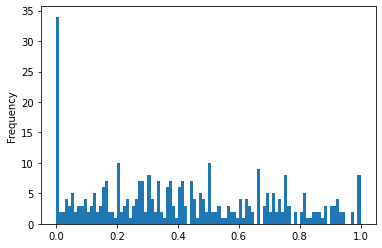

In [51]:
domain_formated.domain_value.plot(kind='hist', bins=100)

In [52]:
domainvalues = domain_formated.set_index("domain").to_dict()['domain_value']
domainvalues

{'5dariyanews.com': 0.5,
 'aajtak.in': 0.3581989247311828,
 'aappune.org': 0.0,
 'abplive.com': 0.4550345887778632,
 'abpnadu.com': 0.1724137931034483,
 'agniban.com': 0.09090909090909091,
 'agrowon.com': 0.14285714285714285,
 'ahmedabadmirror.com': 0.375,
 'akilanews.com': 0.875,
 'altnews.in': 0.03619909502262444,
 'amarujala.com': 0.4510416666666667,
 'anandabazar.com': 0.47368421052631576,
 'andhrajyothy.com': 0.42857142857142855,
 'anewsoffice.com': 0.0,
 'aninews.in': 0.7147887323943662,
 'argusnews.in': 1.0,
 'arunchol.com': 0.0,
 'asianetnews.com': 0.707641196013289,
 'asomiyapratidin.in': 0.38461538461538464,
 'avatarnews.in': 0.6666666666666666,
 'banglahunt.com': 0.9411764705882353,
 'barandbench.com': 0.3984375,
 'beforeprint.in': 0.75,
 'bhaskar.com': 0.27902946273830154,
 'bhaskarhindi.com': 0.4791666666666667,
 'bhaskarlive.in': 0.625,
 'bihardootnews.com': 0.0,
 'biharjharkhandnewsnetwork.com': 0.14285714285714285,
 'business-standard.com': 0.730814639905549,
 'business

In [53]:
newsdata = data.loc[data['domain'].isin(newslist)]
domain_list = newsdata.groupby("author")['domain'].apply(list).reset_index()
domain_list.head()

,author,domain
0,0099Swami,"[indiatimes.com, indiatoday.in, indiatvnews.co..."
1,01Bidar,"[indiatoday.in, prajavani.net, thehindu.com]"
2,02,"[abplive.com, indiatoday.in]"
3,0403,"[abplive.com, amarujala.com, indiatimes.com, n..."
4,07Sharma4u,[abplive.com]


In [54]:
domain_list['domainsize'] = domain_list['domain'].apply(lambda x: len(set(x)))
print(len(domain_list))
print(len(domain_list.loc[domain_list['domainsize']>2]))

6992
4741


In [55]:
multiple_shared_authors = domain_list.loc[domain_list['domainsize']>2]
multiple_shared_authors.head()

,author,domain,domainsize
0,0099Swami,"[indiatimes.com, indiatoday.in, indiatvnews.co...",5
1,01Bidar,"[indiatoday.in, prajavani.net, thehindu.com]",3
3,0403,"[abplive.com, amarujala.com, indiatimes.com, n...",5
5,0914,"[abplive.com, abpnadu.com, business-standard.c...",23
6,1,"[aajtak.in, aninews.in, asianetnews.com, busin...",32


In [56]:
nodes = defaultdict()
edges = defaultdict()

for idx, row in multiple_shared_authors.iterrows():
    authorlist = list(set(row['domain']))
    for a in authorlist:
        if a not in nodes:
            nodes[a] = 1
        else:
            nodes[a]+=1
            
    for i in range(len(authorlist)-1):
        for j in range(i+1, len(authorlist)):
            edgetuple = sorted([authorlist[i], authorlist[j]])
            if (edgetuple[0], edgetuple[1]) not in edges:
                edges[(edgetuple[0], edgetuple[1])] = 1
            else:
                edges[(edgetuple[0], edgetuple[1])] +=1


In [57]:
import networkx as nx

G = nx.Graph()

# for n in nodes.keys():
#     G.add_node(n, size=nodes[n], value=domainvalues[n])

ndlist = []
    
for e in edges:
    if edges[e] > 10:
        if e[0] not in ndlist:
            try:
                G.add_node(e[0], size=nodes[e[0]], party=domainvalues[e[0]])
            except:
                G.add_node(e[0], size=nodes[e[0]], party="unknown")
            ndlist.append(e[0])
        if e[1] not in ndlist:
            try:
                G.add_node(e[1], size=nodes[e[1]], party=domainvalues[e[1]])
            except:
                G.add_node(e[1], size=nodes[e[1]], party='unknown')
            ndlist.append(e[1])

        
        G.add_edge(e[0], e[1], weight=edges[e])

In [58]:
nx.write_gexf(G, "./Jan23_domainsims.gexf", encoding='utf-8')

In [ ]:
edges

In [ ]:
G.nodes

In [ ]:
import requests
from bs4 import BeautifulSoup

In [ ]:
# target url
url = 'https://washingtonpost.com'
  
# making requests instance
reqs = requests.get(url)
  
# using the BeaitifulSoup module
soup = BeautifulSoup(reqs.text, 'html.parser')
  
# displaying the title
print("Title of the website is : ")
for title in soup.find_all('title'):
    print(title.get_text())

In [ ]:
nodelist = list(G.nodes)

In [ ]:
len(nodelist)

In [ ]:
def is_news(text):
    if "news" in text.lower():
        return 1
    
dom